In [0]:
import numpy as np
import sys
import os

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K

Using TensorFlow backend.


In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


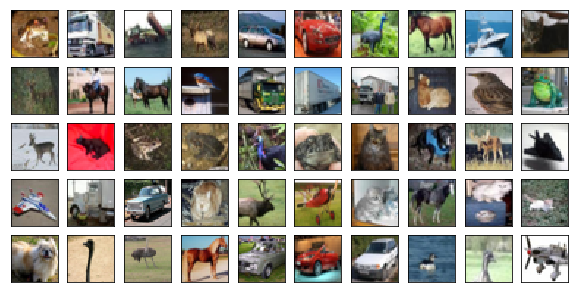

In [5]:
fig = plt.figure(figsize=(10,5))
for i in range(0, 50):
    plt.subplot(5, 10, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.show()

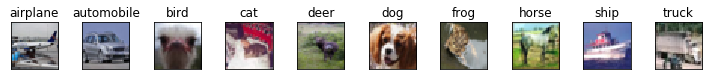

In [6]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(10,5))
for i in range(num_classes):
    ax = plt.subplot(1, 10, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [7]:
print('X_train shape:', X_train.shape)
print('X_test_shape:' , X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
X_test_shape: (10000, 32, 32, 3)
50000 train samples
10000 test samples


In [8]:
X_test.shape

(10000, 32, 32, 3)

In [0]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

In [10]:
# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


## **Model definition**
### Generator

In [11]:
# latent space dimension
latent_dim = 100

init = initializers.RandomNormal(stddev=0.002)

# Generator network
generator = Sequential()

# Can't follow the exact architecture of the paper as the dataset is different and one has to accomodate the sixe of the outputs based on what size of image one needs at the end
# FC: 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))#The generator will take as input arrays of shape (,100) and output arrays of shape (2,2,512)
generator.add(Reshape((2, 2, 512))) 
generator.add(BatchNormalization())
generator.add(ReLU(0.2))


# Conv 1: 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=(2,2), padding='same')) #dimensionality of output space, size of the kernel
generator.add(BatchNormalization()) 
generator.add(ReLU(0.2))

# Conv 2: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=(2,2), padding='same')) #dimensionality of output space, size of the kernel
generator.add(BatchNormalization()) 
generator.add(ReLU(0.2))

# Conv 3: 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=(2,2), padding='same'))
generator.add(BatchNormalization())
generator.add(ReLU(0.2))

# Conv 4: 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=(2,2), padding='same',
                              activation='tanh'))

In [12]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
re_lu_2 (ReLU)               (None, 4, 4, 256)        

## **Discriminator**

In [0]:
# image shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [14]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 256)        

### **Compile** **Discriminator**

In [0]:
# Wasserstein objective
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [17]:
# Following parameter and optimizer set as recommended in paper
# optimizer = Adam(lr=0.0002)


# discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
#                       metrics=['binary_accuracy'])

discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss=wasserstein_loss, metrics=['accuracy'])

### **Combined** **Network**

In [0]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)

# The discriminator takes generated images as input and determines validity
results = discriminator(img)

# The combined model (discriminator and generative)
d_g = Model(inputs=z, outputs=results, name='wgan')

d_g.compile(Adam(lr=0.0002, beta_1=0.5), loss=wasserstein_loss,
            metrics=['accuracy'])

### **GAN model visualization**

In [19]:
d_g.summary()

Model: "wgan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         4516739   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 4312193   
Total params: 8,828,932
Trainable params: 4,514,819
Non-trainable params: 4,314,113
_________________________________________________________________


### **Fit** **Model**



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
epoch = 1/5, d_loss=0.454, g_loss=0.454                                                                                                     


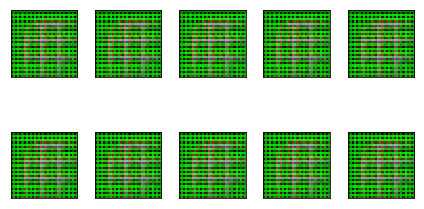

epoch = 2/5, d_loss=0.454, g_loss=0.454                                                                                                     
epoch = 3/5, d_loss=0.454, g_loss=0.454                                                                                                     
epoch = 4/5, d_loss=0.454, g_loss=0.454                                                                                                     
epoch = 5/5, d_loss=0.454, g_loss=0.454                                                                                                     
epoch = 6/5, d_loss=0.454, g_loss=0.454                                                                                                     


In [20]:
epochs = 5
batch_size = 32
n_discriminator=5
clip_value = 0.01

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        for _ in range(n_discriminator):            
             # Train Discriminator weights
            discriminator.trainable = True

            # Real samples
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                       y=real)

            # Fake Samples
            z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
            X_fake = generator.predict_on_batch(z)
            d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)

            # Discriminator loss
            d_loss_batch = (d_loss_real[0] + d_loss_fake[0])
            
            # Clip discriminator weights
            for l in discriminator.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                l.set_weights(weights)


        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )

    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1)
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()